In [468]:
import caffe
import skimage
from skimage import img_as_float 
import os
import pandas as pd
import sklearn.feature_extraction as skf
import numbers
from numpy.lib.stride_tricks import as_strided
from itertools import product
from sklearn.metrics import confusion_matrix, accuracy_score, make_scorer
import numpy as np
import scipy
import collections
import random as rand
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from os import listdir
from os.path import isfile, join
import numpy as np 
import skimage.io as io
import matplotlib.pyplot as plt
from utils_egc_ex import reconstruct_img_from_patchified, extract_patches, compute_corner_patches, compute_n_patches
import pylab
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import json
from pprint import pprint
import scipy.io as sio
from PIL import Image
from caffe import layers as L, params as P # Shortcuts to define the net prototxt.
import os.path as osp
import random
from random import randint
caffe.set_mode_gpu()
#import display_network
%matplotlib inline

In [494]:
net_egc = caffe.Net('/home/jsotaloram/active_learning/labels_miccai/modelo1_Ex_batch.prototxt',
                    '/home/jsotaloram/active_learning/labels_miccai/models/model_egc_1696samplesseen.caffemodel'
                    ,caffe.TEST)
net = caffe.Net('/home/ojperdomoc/Predict_mask/Modelo1/modelo1.prototxt',                                                               
                '/home/ojperdomoc/Predict_mask/Modelo1/modelo4.caffemodel',                                                             
                caffe.TEST)                                                                                                             

net_m = net_egc
mean_root = '/home/ojperdomoc/Predict_mask/Modelo1/'
transformer = caffe.io.Transformer({'data': net_m.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
#transformer.set_mean('data', np.load('/home/jsotaloram/active_learning/labels_miccai/mean_DS000F4H.npy')) # mean pixel
transformer.set_mean('data', np.load('/home/ojperdomoc/Predict_mask/Modelo1/mean4.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

In [653]:
#Patchifying original image
test_image_ex =  "/home/ojperdomoc/Predict_mask/DS000U30.JPG"
original = skimage.img_as_float(skimage.io.imread(test_image_ex)).astype(np.float32)

#original = Image.open(test_image_ex)
#width, height = original.size
#original = np.array(original,np.float32)
patches_img_R, indexing_strides_r, patch_indices_shape_r, slices_r = extract_patches(original[:,:,0], patch_shape=48, extraction_step=8)
patches_img_G, indexing_strides_g, patch_indices_shape_g, slices_g = extract_patches(original[:,:,1], patch_shape=48, extraction_step=8)
patches_img_B, indexing_strides_b, patch_indices_shape_b, slices_b = extract_patches(original[:,:,2], patch_shape=48, extraction_step=8)

In [655]:
patches_img_R.shape
115*175

20125

/home/ojperdomoc/Parches48/Modelo_4/Test/1/957_957_1.png
-74894.0
{'loss': array(22.019710540771484, dtype=float32), 'prob': array([[  2.73502443e-10,   1.00000000e+00]], dtype=float32), 'accuracy': array(0.0, dtype=float32)}


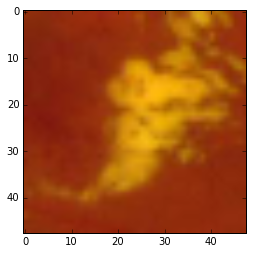

In [538]:
#sampled_patch = 
path_pt_n = dataset_paths_test[1937][1]
print path_pt_n

trans_patch = transformer.preprocess('data', caffe.io.load_image(path_pt_n))
plt.imshow(Image.open(path_pt_n))
#plt.imshow(transformer.deprocess('data',trans_patch))

print trans_patch.sum()
net_m.set_input_arrays(np.expand_dims(trans_patch, axis=0),  np.array([0], np.float32))  

#net_m.blobs['data'].data[...] = trans_patch                                                                                         
output = net_m.forward()
print output


{'loss': array(8.645465850830078, dtype=float32), 'prob': array([[  1.75922629e-04,   9.99824107e-01]], dtype=float32), 'accuracy': array(0.0, dtype=float32)}


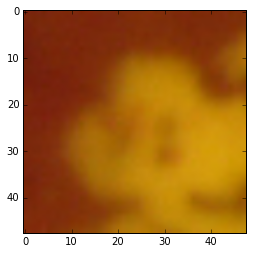

In [566]:
test_image_ex =  "/home/ojperdomoc/Predict_mask/DS000U30.JPG"
original = skimage.img_as_float(skimage.io.imread(test_image_ex)).astype(np.float32)
ex_bpatch = original[480:528, 460:508,:]
#ex_bpatch = original[440:488, 440:488,:]

#plt.imshow(original[460:600, 420:560,:])
plt.imshow(ex_bpatch)

temp_patch_rec = np.array(ex_bpatch, np.float32)
trans_patch_rec = transformer.preprocess('data', temp_patch_rec)
#net_m.set_input_arrays(np.expand_dims(np.ascontiguousarray(ex_bpatch, dtype=np.float32), axis=0),  np.array([0], np.float32))  
net_m.set_input_arrays(np.expand_dims(np.ascontiguousarray(trans_patch_rec, dtype=np.float32), axis=0),  np.array([0], np.float32))  
#net_m.blobs['data'].data[...] = trans_patch                                                                                         
output = net_m.forward()
print output


In [571]:
print patches_img_R.shape
print output['prob'][0]
a = []
a.append

(115, 175, 48, 48)
[  1.75922629e-04   9.99824107e-01]


In [658]:
predictions_test_img = []
for i in range(patches_img_R.shape[0]):
    predictions_test_row = []
    for j in range(patches_img_R.shape[1]):        
        sample_patch_coord = [i, j]
        rec_patch = np.zeros((48,48,3),np.float32)
        rec_patch[:,:,0] = patches_img_R[sample_patch_coord[0],sample_patch_coord[1]]
        rec_patch[:,:,1] = patches_img_G[sample_patch_coord[0],sample_patch_coord[1]]
        rec_patch[:,:,2] = patches_img_B[sample_patch_coord[0],sample_patch_coord[1]]
        temp_patch_rec = np.array(rec_patch, np.float32)
        trans_patch_rec = transformer.preprocess('data', temp_patch_rec)
        net_m.set_input_arrays(np.expand_dims(np.ascontiguousarray(trans_patch_rec, dtype=np.float32), axis=0),  np.array([0], np.float32))  
        output = net_m.forward()
        predictions_test_row.append(np.float32(output['prob'][0][1]))
        #if predictions_test_row[-1] > 0.5:
        #    print "Found exudate at patch "  + str(i) + '-' +str(j)
    predictions_test_img.append(predictions_test_row)
    #print i
#print np.sum(rec_patch)
#plt.imshow(rec_patch)

In [635]:
arr_preds = np.array(predictions_test_img, np.float32)
#flat_preds = arr_preds.reshape(115*175,2)
#print flat_preds.shape
print np.sum(flat_preds,axis=0)
print arr_preds[90,109]
print arr_preds.shape

[  2.01249980e+04   5.75040877e-02]
0.724569
(115, 175)


In [651]:
#Building the mask
patches_mask = np.ones(patches_img_R.shape)
for i in range(patches_mask.shape[0]):
    for j in range(patches_mask.shape[1]):
        patches_mask[i,j] = np.kron(arr_preds[i,j],patches_mask[i,j])
    #print i
rec_mask_test = reconstruct_img_from_patchifiedV2(patches_mask, array_corners, original.shape[0:2], 48)


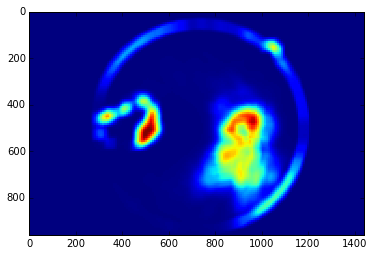

In [652]:
plt.imshow(rec_mask_test)

In [661]:
plt.imsave('/home/jsotaloram/active_learning/labels_miccai/results/mask_30.png', rec_mask_test)

In [601]:
array_corners[60,58]

array([480, 464])

(115, 175, 2)
115 175
[888 872]
1089.02
[ 0.44800442  0.55199558]


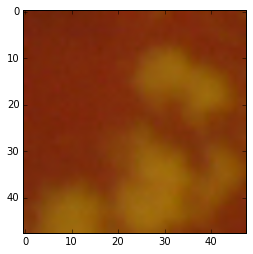

In [622]:
array_corners,tpx,tpy = compute_corner_patches([original.shape[0],original.shape[1]],8,8)
print array_corners.shape
print tpx, tpy
sample_patch_coord = array_corners[111,109]
patch_coord = [48,48]
print sample_patch_coord
#print array_corners[sample_patch_coord[0],sample_patch_coord[1]]
#orig_coord = array_corners[sample_patch_coord[0],sample_patch_coord[1]]
orig_sampled_patch = original[sample_patch_coord[0]:sample_patch_coord[0]+48, sample_patch_coord[1]:sample_patch_coord[1]+48,:]

rec_patch = np.zeros((48,48,3),np.float32)
rec_patch[:,:,0] = patches_img_R[patch_coord[0],patch_coord[1]]
rec_patch[:,:,1] = patches_img_G[patch_coord[0],patch_coord[1]]
rec_patch[:,:,2] = patches_img_B[patch_coord[0],patch_coord[1]]
temp_patch_rec = np.array(rec_patch, np.float32)
trans_patch_rec = transformer.preprocess('data', temp_patch_rec)
net_m.set_input_arrays(np.expand_dims(np.ascontiguousarray(trans_patch_rec, dtype=np.float32), axis=0),  np.array([0], np.float32))  
output = net_m.forward()
predictions_test_row.append(output['prob'][0])



print np.sum(orig_sampled_patch)
plt.imshow(rec_patch)
print output['prob'][0]


In [611]:
8.18581757e-05 + 0.1

0.1000818581757

In [474]:
rec_imgv2_r = reconstruct_img_from_patchifiedV2(patches_img_R, array_corners, original.shape[0:2], 48)
rec_imgv2_g = reconstruct_img_from_patchifiedV2(patches_img_G, array_corners, original.shape[0:2], 48)
rec_imgv2_b = reconstruct_img_from_patchifiedV2(patches_img_B, array_corners, original.shape[0:2], 48)
rec_fromPatches = np.zeros(original.shape)
rec_fromPatches[:,:,0] = rec_imgv2_r
rec_fromPatches[:,:,1] = rec_imgv2_g
rec_fromPatches[:,:,2] = rec_imgv2_b


In [475]:
rec_imgv2_r[500:700,500:700]

array([[ 25.27058887,  24.56470656,  24.70588303, ...,  17.082353  ,
         16.94117653,  16.80000007],
       [ 26.54117703,  26.40000057,  26.25882411, ...,  16.94117653,
         17.082353  ,  16.94117653],
       [ 27.81176519,  27.67058873,  28.23529458, ...,  17.22352946,
         17.36470592,  17.22352946],
       ..., 
       [ 18.63529515,  19.200001  ,  19.48235393, ...,  21.88235378,
         22.02353024,  21.88235378],
       [ 18.77647161,  19.05882454,  19.200001  , ...,  21.88235378,
         21.88235378,  22.02353024],
       [ 18.0705893 ,  18.35294223,  19.05882454, ...,  21.88235378,
         22.02353024,  21.88235378]])

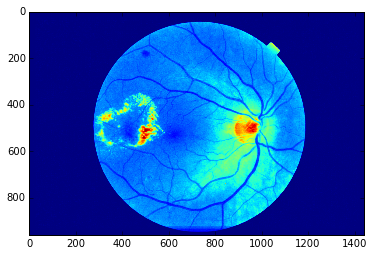

In [478]:
plt.imshow(rec_imgv2_g)

In [334]:
print indexing_strides_r
print patch_indices_shape_r
print slices_r

(138240, 96)
[115 175]
[slice(None, None, 8), slice(None, None, 8)]


(48, 48)
(20125, 48, 48)


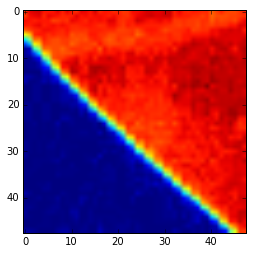

In [320]:
print patches_img_R[100,50].shape
pp  = patches_img_R.reshape(patches_img_R.shape[0]*patches_img_R.shape[1], patches_img_R.shape[2], patches_img_R.shape[3])
print pp.shape
plt.imshow(patches_img_R[100,50])

In [312]:
patches_img_R[0,0].shape

(48, 48)

In [46]:
def loadSamples(path_part):                                                                                                             
    labels = os.listdir(path_part)                                                                                                      
    dataset = np.empty((0,2))                                                                                                           
                                                                                                                                        
    for label in labels:                                                                                                                
        samples = sorted(os.listdir(os.path.join(path_part, label)))                                                                    
        for sample in samples:                                                                                                          
            path = os.path.join(path_part, label, sample)                                                                               
            if os.path.isfile(path):                                                                                                    
                dataset = np.concatenate((dataset, np.array([[label, path]])), axis=0)                                                  
    return dataset                                                                                                                      
                                                                                                                                        

paths_val_file = '/home/ojperdomoc/Parches48/Modelo_4/Validation/'
paths_train_file = '/home/ojperdomoc/Parches48/Modelo_4/Training/'
paths_test_file = '/home/ojperdomoc/Parches48/Modelo_4/Test/'

dataset_paths_train = loadSamples(paths_train_file)
dataset_paths_val = loadSamples(paths_val_file)
dataset_paths_test = loadSamples(paths_test_file)
i=0
mean_root = '/home/ojperdomoc/Predict_mask/Modelo1/'

#loading data                                                                                                                           
train_size = len(dataset_paths_train)
val_size = len(dataset_paths_val)
test_size = len(dataset_paths_test)
data4D = np.zeros([train_size+48,3,48,48],np.float32)
data4DL = np.zeros([train_size+48,1,1,1],np.float32)
data4D_val = np.zeros([val_size,3,48,48],np.float32)
data4DL_val = np.zeros([val_size,1,1,1],np.float32)
data4D_test = np.zeros([test_size+24,3,48,48],np.float32)
data4DL_test = np.zeros([test_size+24,1,1,1],np.float32)

for i in range(len(dataset_paths_train)+48):
    if i<len(dataset_paths_train):
        #Substracting the mean, swaping axes, et al                                                                                     
        trans_patch = transformer.preprocess('data', caffe.io.load_image(dataset_paths_train[i][1]))
        data4D[i] = trans_patch
        data4DL[i,:,:,:] = np.array(dataset_paths_train[i][0])
    else:
        data4D[i,:,:,:] = data4D[0,:,:,:]
        data4DL[i,:,:,:] = data4DL[0,:,:,:]
for i in range(len(dataset_paths_val)):
    trans_patch = transformer.preprocess('data', caffe.io.load_image(dataset_paths_val[i][1]))
    data4D_val[i] = trans_patch
    data4DL_val[i,:,:,:] = np.array(dataset_paths_val[i][0])

for i in range(len(dataset_paths_test)+24):
    if i<len(dataset_paths_test):
        trans_patch = transformer.preprocess('data', caffe.io.load_image(dataset_paths_test[i][1]))
        data4D_test[i] = trans_patch
        data4DL_test[i,:,:,:] = np.array(dataset_paths_test[i][0])
    else:
        data4D_test[i,:,:,:] = data4D_test[0,:,:,:]
        data4DL_test[i,:,:,:] = data4DL_test[0,:,:,:]

bin_ex_labels_val = []
for i in range(data4DL_val.shape[0]):
    if np.sum(data4DL_val[i].flatten())>0:
        bin_ex_labels_val.append(1)
    else:
        bin_ex_labels_val.append(0)
bin_ex_labels_test = []
for i in range(data4DL_test.shape[0]):
    if np.sum(data4DL_test[i].flatten())>0:
        bin_ex_labels_test.append(1)
    else:
        bin_ex_labels_test.append(0)


print "Data loaded! === Begining of Active Selection Net Testing"
print dataset_paths_train[0]
print dataset_paths_val[0]
print dataset_paths_test[0]


Data loaded! === Begining of Active Selection Net Testing
['0'
 '/home/ojperdomoc/Parches48/Modelo_4/Training/0/C0001273_1008_1008_0.jpg']
['0'
 '/home/ojperdomoc/Parches48/Modelo_4/Validation/0/C0014792_1008_1008_0.jpg']
['0' '/home/ojperdomoc/Parches48/Modelo_4/Test/0/C0002422_1008_1008_0.jpg']


-250935.0
{'prob': array([[  9.99952555e-01,   4.74723092e-05]], dtype=float32)}


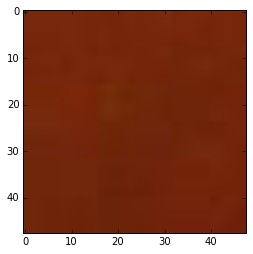

In [130]:
#Trying to locate this on my patches and predicting it 


In [115]:
#['0' '/home/ojperdomoc/Parches48/Modelo_4/Test/0/DS000U30_320_560_0.jpg']
count = 0

for i in range(len(dataset_paths_test)):
    k = dataset_paths_test[i]
    print k, count
    count = count +1

['0' '/home/ojperdomoc/Parches48/Modelo_4/Test/0/C0002422_1008_1008_0.jpg'] 0
['0' '/home/ojperdomoc/Parches48/Modelo_4/Test/0/C0002422_1008_1056_0.jpg'] 1
['0' '/home/ojperdomoc/Parches48/Modelo_4/Test/0/C0002422_1008_1104_0.jpg'] 2
['0' '/home/ojperdomoc/Parches48/Modelo_4/Test/0/C0002422_1008_1152_0.jpg'] 3
['0' '/home/ojperdomoc/Parches48/Modelo_4/Test/0/C0003166_1008_1008_0.jpg'] 4
['0' '/home/ojperdomoc/Parches48/Modelo_4/Test/0/C0003166_1008_1056_0.jpg'] 5
['0' '/home/ojperdomoc/Parches48/Modelo_4/Test/0/C0003166_1008_1104_0.jpg'] 6
['0' '/home/ojperdomoc/Parches48/Modelo_4/Test/0/C0003166_1008_1152_0.jpg'] 7
['0' '/home/ojperdomoc/Parches48/Modelo_4/Test/0/C0003166_1008_1200_0.jpg'] 8
['0' '/home/ojperdomoc/Parches48/Modelo_4/Test/0/C0003166_1008_1248_0.jpg'] 9
['0' '/home/ojperdomoc/Parches48/Modelo_4/Test/0/C0003166_1008_1296_0.jpg'] 10
['0' '/home/ojperdomoc/Parches48/Modelo_4/Test/0/C0003166_1008_1344_0.jpg'] 11
['0' '/home/ojperdomoc/Parches48/Modelo_4/Test/0/C0003166_1008

In [499]:
987 + 985

1972

In [560]:
trans_patch = transformer.preprocess('data', caffe.io.load_image(dataset_paths_test[20][1]))
temp_patch_rec = np.array(rec_patch, np.float32)
trans_patch_rec = transformer.preprocess('data', temp_patch_rec)

cli = caffe.io.load_image(dataset_paths_test[100][1])
print trans_patch.sum()


print trans_patch_rec.sum()
print trans_patch_rec

-231684.0
-253392.0
[[[ -35.1219635   -34.1219635   -34.1219635  ...,  -23.12196159
    -21.12196159  -16.12196159]
  [ -35.1219635   -34.1219635   -34.1219635  ...,  -24.12196159
    -22.12196159  -25.12196159]
  [ -35.1219635   -34.1219635   -34.1219635  ...,  -22.12196159
    -24.12196159  -25.12196159]
  ..., 
  [ -22.12196159  -16.12196159  -24.12196159 ...,  -15.12196159
    -22.12196159  -26.12196159]
  [ -22.12196159  -18.12196159  -22.12196159 ...,  -14.12196159
    -17.12196159  -20.12196159]
  [ -22.12196159  -19.12196159  -22.12196159 ...,  -13.12196159
    -20.12196159  -22.12196159]]

 [[ -81.665802    -81.665802    -81.665802   ...,  -41.66579819
    -38.66579819  -38.66579819]
  [ -80.665802    -81.665802    -81.665802   ...,  -40.66579819
    -39.66579819  -41.66579819]
  [ -80.665802    -81.665802    -79.665802   ...,  -39.66579819
    -43.66579819  -41.66579819]
  ..., 
  [ -41.66579819  -37.66579819  -38.66579819 ...,   18.33420181
     16.33420181   12.33420181]
  

In [93]:
pred_labels_test_ex_d = []
num_patches = compute_n_patches(original.shape[0], original.shape[1], 48, 48, 8)
#Parsing the patches to caffe's tensor with the appropiate transformation                                                               
for i in range(patches_img_R.shape[0]):
    for j in range(patches_img_R.shape[1]): 
        rec_patch = np.zeros((48,48,3))
        rec_patch[:,:,0] = patches_img_R[i,j]
        rec_patch[:,:,1] = patches_img_G[i,j]
        rec_patch[:,:,2] = patches_img_B[i,j]
        #rec_patch
        temp_patch = np.array(rec_patch, np.float32)
        trans_patch = transformer.preprocess('data', temp_patch)
        
        #net_m.set_input_arrays(np.expand_dims(trans_patch, axis=0),  np.array([0], np.float32))                                            
        net_m.blobs['data'].data[...] = trans_patch

        output = net_m.forward()
        pred_labels_test_ex_d.append(output['prob'])
        #print output                                                                                                                       
        if (i+j)%1000 == 0:
            print "Computing predictions for exudate patch " +str(i)
            print "I have found " + str(np.array(pred_labels_test_ex_d)[:,0,0].sum()) + " Non exud"
            print "I have found " + str(np.array(pred_labels_test_ex_d)[:,0,1].sum()) + " Exud"
            np.save('/home/jsotaloram/active_learning/labels_miccai/results/dense_mask_DS000U30_patches.npy',pred_labels_test_ex_d)

np.save('/home/jsotaloram/active_learning/labels_miccai/results/dense_mask_DS000U30_m.npy',pred_labels_test_ex_d)


Computing predictions for exudate patch 0
I have found 1.0 Non exud
I have found 5.61801e-09 Exud


In [45]:
5.61801e-09 * 20125

0.00011306245125000001

In [94]:
ll = np.array(pred_labels_test_ex_d)
ll = ll[:,0,:]
ll[:,1].sum()

0.00011382352

(115, 175, 48, 48)
(960, 1440, 3)
The number of patches is 20125
20125


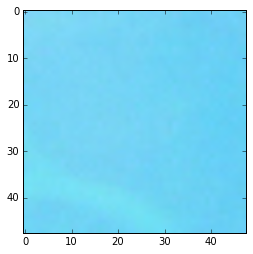

In [68]:
i = 80
print patches_img_R.shape
print original.shape
rec_patch = np.zeros((48,48,3))
rec_patch[:,:,0] = patches_img_R[i,i]
rec_patch[:,:,1] = patches_img_G[i,i]
rec_patch[:,:,2] = patches_img_B[i,i]
plt.imshow(rec_patch)
print "The number of patches is " +  str(compute_n_patches(original.shape[0], original.shape[1], 48, 48, 8))
print 115*175

In [197]:
115*48 - (16*115)

3680

In [218]:
patches_rgb = np.zeros((115, 175, 48, 48,3))
reconstructed_patch_img = np.zeros((patches_img_R.shape[0]*patches_img_R.shape[2],patches_img_R.shape[1]*patches_img_R.shape[3],3))
for i in range(patches_img_R.shape[0]):
    for j in range(patches_img_R.shape[1]): 
        rec_patch = np.zeros((48,48,3))
        rec_patch[:,:,0] = patches_img_R[i,j]
        rec_patch[:,:,1] = patches_img_G[i,j]
        rec_patch[:,:,2] = patches_img_B[i,j]
        patches_rgb[i,j,:,:,:] = rec_patch
        reconstructed_patch_img[i*48:(i*48)+48,j*48:(j*48)+48,:] = rec_patch

In [302]:
patches_rgb = np.zeros((115, 175, 48, 48,3))
reconstructed_patch_img = np.zeros((patches_img_R.shape[0]*patches_img_R.shape[2],patches_img_R.shape[1]*patches_img_R.shape[3],3))
for i in range(patches_img_R.shape[0]):
    for j in range(patches_img_R.shape[1]): 
        rec_patch = np.zeros((48,48,3))
        rec_patch[:,:,0] = patches_img_R[i,j]
        rec_patch[:,:,1] = patches_img_G[i,j]
        rec_patch[:,:,2] = patches_img_B[i,j]
        patches_rgb[i,j,:,:,:] = rec_patch
        reconstructed_patch_img[i*48:(i*48)+48,j*48:(j*48)+48,:] = rec_patch

In [243]:
patches_rgb = patches_rgb.reshape(115*175,48,48,3)
patches_img_R = patches_img_R.reshape(115*175,48,48)

In [244]:
print patches_rgb.shape
print patches_img_R.shape


(20125, 48, 48, 3)
(20125, 48, 48)


In [288]:
img_reconstructed_patches   = reconstruct_from_patches_2d(patches_rgb, (960, 1440,3))
print "==========================================================================="
img_reconstructed_patches_R = reconstruct_from_patches_2d(patches_img_R, (960, 1440))

960 1440
48 48
(960, 1440, 3)
913
1393
960 1440
48 48
(960, 1440)
913
1393


In [295]:
patches = patches_rgb
image_size = (960, 1440)
i_h, i_w = image_size[:2]
print i_h, i_w
p_h, p_w = patches.shape[1:3]
print p_h, p_w
img = np.zeros(image_size)
print img.shape
# compute the dimensions of the patches array
n_h = i_h - p_h + 1
print n_h
n_w = i_w - p_w + 1
print n_w

KK  = zip(patches_img_R, product(range(n_h), range(n_w)))
print len(KK)
print 913*1393


960 1440
48 48
(960, 1440)
913
1393
20125
1271809


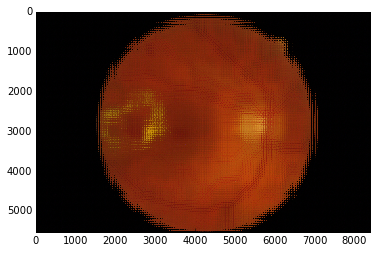

In [303]:
plt.imshow(reconstructed_patch_img)

In [81]:
img = skimage.img_as_float(skimage.io.imread('foo_img.jpg')).astype(np.float32)
imgR = img[:,:,0]
imgG = img[:,:,1]
imgB = img[:,:,2]

print img.shape
patches = patchify(imgR, (39,39))
contiguous_patches = np.ascontiguousarray(patches)
contiguous_patches.shape = (-1, 39**2)


(236, 240, 3)


In [88]:
img = np.ascontiguousarray(imgR)  # won't make a copy if not needed
patch_shape = (39,39)
X, Y = img.shape
x, y = patch_shape
shape = ((X-x+10), (Y-y+10), x, y) # number of patches, patch_shape
# The right strides can be thought by:
# 1) Thinking of `img` as a chunk of memory in C order
# 2) Asking how many items through that chunk of memory are needed when indices
#    i,j,k,l are incremented by one
strides = img.itemsize*np.array([Y, 10, Y, 10])
np.lib.stride_tricks.as_strided(img, shape=shape, strides=strides)

In [95]:
img = np.ascontiguousarray(np.array([[1,2,3],[4,5,6]]))  # won't make a copy if not needed
patch_shape = (2,2)
X, Y = img.shape
print X, Y
x, y = patch_shape
print x, y
shape = ((X-x+1), (Y-y+1), x, y) # number of patches, patch_shape
print shape
# The right strides can be thought by:
# 1) Thinking of `img` as a chunk of memory in C order
# 2) Asking how many items through that chunk of memory are needed when indices
#    i,j,k,l are incremented by one
strides = img.itemsize*np.array([Y, 1, Y, 1])
print strides
np.lib.stride_tricks.as_strided(img, shape=shape, strides=strides)

2 3
2 2
(1, 2, 2, 2)
[24  8 24  8]


array([[[[1, 2],
         [4, 5]],

        [[2, 3],
         [5, 6]]]])

In [97]:
img.itemsize

8

In [253]:
n=5
m=6
a = np.arange(1,n*m+1).reshape(n,m)
print(a)
# [[ 1  2  3  4  5]
#  [ 6  7  8  9 10]
#  [11 12 13 14 15]
#  [16 17 18 19 20]]
sz = a.itemsize
h,w = a.shape
bh,bw = 2,2

shape = (h/(bh), w/(bw), bh, bw)

print "There are: " + str((h/bh) * (w/bw))

print(shape)
# (2, 2, 2, 2)

strides = sz*np.array([w*(bh),bw,w,1])
print(strides)
# [40  8 20  4]

blocks=np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
print(blocks)
print blocks.shape

[[ 1  2  3  4  5  6]
 [ 7  8  9 10 11 12]
 [13 14 15 16 17 18]
 [19 20 21 22 23 24]
 [25 26 27 28 29 30]]
There are: 6
(2, 3, 2, 2)
[96 16 48  8]
[[[[ 1  2]
   [ 7  8]]

  [[ 3  4]
   [ 9 10]]

  [[ 5  6]
   [11 12]]]


 [[[13 14]
   [19 20]]

  [[15 16]
   [21 22]]

  [[17 18]
   [23 24]]]]
(2, 3, 2, 2)


In [254]:
patches_skf = extract_patches(a, 2, 1)

In [313]:
print a
print patches_skf.shape
print reconstruct_from_patches_2d(patches_skf,(5,6))

[[ 1  2  3  4  5  6]
 [ 7  8  9 10 11 12]
 [13 14 15 16 17 18]
 [19 20 21 22 23 24]
 [25 26 27 28 29 30]]
(4, 5, 2, 2)
5 6
2 2
4
5
[[  1.   2.   3.   4.   5.   6.]
 [  4.   5.   6.   7.   8.   9.]
 [  4.   5.   6.   7.   8.   9.]
 [  4.   5.   6.   7.   8.   9.]
 [  7.   8.   9.  10.  11.  12.]]


In [142]:
compute_n_patches(5, 5, 2, 2, 1, max_patches=None)

16

In [235]:
i,j = 0,0
img[i:i + p_h, j:j + p_w] == patches[0,0]

array([[ True,  True],
       [ True,  True]], dtype=bool)

In [175]:
len(zip(patches_skf, product(range(n_h), range(n_w))))

4